In [309]:
import torch
import json
import random
import gc
import matplotlib.pyplot as plt
import numpy as np
import lightning.pytorch as pl
from pathlib import Path
from torch.utils.data import Dataset, Subset, DataLoader
from PIL import Image
from typing import List, Dict

In [310]:
PATH_ROOT = Path(r'C:\Caesar\Machine_Learning\projects\my_cityscapes_scripts\data')
PATH_SAVE_EXPERIMENT = Path(r'C:\Caesar\Machine_Learning\projects\detr\experiments\detection_0')
train_annFile = Path(r'C:\Caesar\Machine_Learning\projects\my_cityscapes_scripts\data\annotations\cityscapes_instances_train.json')
val_annFile = Path(r'C:\Caesar\Machine_Learning\projects\my_cityscapes_scripts\data\annotations\cityscapes_instances_val.json')

- Utility class for Cityscapes in COCO Detection format

In [311]:
class CityscapesDetectionAPI:

    def __init__(self, root: Path, annFile: Path):
        self.root = root
        self.annFile = annFile

        if not self.annFile.exists():
            raise FileNotFoundError(f'Annotation file not found at {self.annFile}.')

        print('loading annotations into memory...')
        with open(self.annFile, 'r') as f:
            self.annotations = json.load(f)
        
        print('creating index...')
        self.categories = self.annotations['categories']
        for cat in self.categories: cat['hasInstances'] = True if cat['hasInstances'] == 1 else False
        self.images = self.annotations['images']
        self.annotations = self.annotations['annotations']

        print('index created!')
    
    def loadImg(self, image_id):
        return self.loadImgs([image_id])[0]
    
    def loadAnns(self, image_id):
        return [ann for ann in self.annotations if ann['image_id'] == image_id]

    def loadImgs(self, image_ids):
        images = list(filter(lambda img: img['id'] in image_ids, self.images))
        return [Image.open(self.root / img['file_name']) for img in images]
    
    def getImageIds(self):
        return [img['id'] for img in self.images]
    
    def getCategoryById(self, category_id):
        return next((cat for cat in self.categories if cat['id'] == category_id), None)

    def __getitem__(self, image_id):
        return self.loadImg(image_id), self.loadAnns(image_id)

In [312]:
cityscapesAPIs = {
    'train': CityscapesDetectionAPI(root=PATH_ROOT, annFile=train_annFile),
    'val': CityscapesDetectionAPI(root=PATH_ROOT, annFile=val_annFile)
}

loading annotations into memory...
creating index...
index created!
loading annotations into memory...
creating index...
index created!


In [313]:
cityscapesAPIs['train'].categories

[{'id': 0, 'name': 'road', 'supercategory': 'flat', 'hasInstances': False},
 {'id': 1, 'name': 'sidewalk', 'supercategory': 'flat', 'hasInstances': False},
 {'id': 2,
  'name': 'building',
  'supercategory': 'construction',
  'hasInstances': False},
 {'id': 3,
  'name': 'wall',
  'supercategory': 'construction',
  'hasInstances': False},
 {'id': 4,
  'name': 'fence',
  'supercategory': 'construction',
  'hasInstances': False},
 {'id': 5, 'name': 'pole', 'supercategory': 'object', 'hasInstances': False},
 {'id': 6,
  'name': 'traffic light',
  'supercategory': 'object',
  'hasInstances': False},
 {'id': 7,
  'name': 'traffic sign',
  'supercategory': 'object',
  'hasInstances': False},
 {'id': 8,
  'name': 'vegetation',
  'supercategory': 'nature',
  'hasInstances': False},
 {'id': 9,
  'name': 'terrain',
  'supercategory': 'nature',
  'hasInstances': False},
 {'id': 10, 'name': 'sky', 'supercategory': 'sky', 'hasInstances': False},
 {'id': 11, 'name': 'person', 'supercategory': 'human'

In [314]:
class CityscapesDetectionDataset(Dataset):
    
    def __init__(self, cityscapesAPI: CityscapesDetectionAPI, processor=None):
        self.cityscapesAPI = cityscapesAPI
        self.processor = processor

        self.image_ids = self.cityscapesAPI.getImageIds()

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img, target = self.cityscapesAPI[image_id]
        
        # -------------------------------------------------------
        # DATA AUGMENTATION
        # -------------------------------------------------------

        if self.processor is not None:
            target = {'image_id': image_id, 'annotations': target}
            encoding = self.processor(images=img, annotations=target, return_tensors="pt")

            pixel_values = encoding["pixel_values"].squeeze()
            target = encoding["labels"][0]

            return pixel_values, target

        return img, target

In [315]:
val_dataset = CityscapesDetectionDataset(cityscapesAPI=cityscapesAPIs['val'])

In [316]:
image, target = val_dataset[2]

In [317]:
target[0].keys()

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])

In [318]:
def showAnn(image: Image, target: List[Dict[str, any]], include_noInstances: bool = False):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)

    for instance in target:
        category = cityscapesAPIs['train'].getCategoryById(instance['category_id'])
        if category['hasInstances'] == False and include_noInstances == False:
            continue

        x, y, w, h = instance['bbox']
        # pick random color for the box
        color = list(np.random.random(size=3))
        # draw the box
        ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color=color, linewidth=2))
        ax.text(x, y, category['name'], fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
        
    plt.axis('off')
    plt.show()

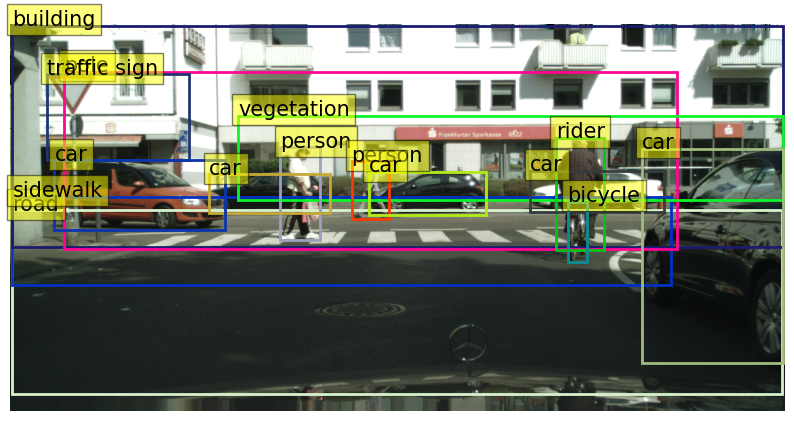

In [319]:
showAnn(image, target, include_noInstances=True)

- Load Image Processor for detection

In [320]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [321]:
def collate_fn(batch):
    pixel_values, labels = list(zip(*batch))
    encoding = processor.pad(pixel_values, return_tensors="pt")
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

In [322]:
train_dataset = CityscapesDetectionDataset(cityscapesAPI=cityscapesAPIs['train'], processor=processor)
val_dataset = CityscapesDetectionDataset(cityscapesAPI=cityscapesAPIs['val'], processor=processor)

In [323]:
train_dataset = Subset(train_dataset, random.sample(range(0, len(train_dataset)), 1))
val_dataset = Subset(val_dataset, random.sample(range(0, len(val_dataset)), 1))

In [324]:
train_dataLoader = DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)
val_dataLoader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn)

- Explore the batch's format DETR expects for Detection

In [325]:
batch = next(iter(val_dataLoader))

In [326]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [327]:
batch['pixel_values'].shape, batch['pixel_mask'].shape

(torch.Size([1, 3, 666, 1332]), torch.Size([1, 666, 1332]))

In [328]:
batch['labels'][0].keys()

dict_keys(['size', 'image_id', 'class_labels', 'boxes', 'area', 'iscrowd', 'orig_size'])

In [329]:
MAX_CLASS_ID = max([cat['id'] for cat in cityscapesAPIs['train'].categories])
MAX_CLASS_ID

18

- Load segmentation model and extract the detection model from it to fine-tune. In the end we will save the segmentation model together with the fine-tuned detection model.

In [330]:
from transformers import DetrForSegmentation

model = DetrForSegmentation.from_pretrained(
    "facebook/detr-resnet-50-panoptic", 
    num_labels=MAX_CLASS_ID + 1, 
    ignore_mismatched_sizes=True)

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForSegmentation were not initialized from th

In [331]:
detection_Detr = model.detr

In [332]:
detection_Detr.class_labels_classifier

Linear(in_features=256, out_features=20, bias=True)

In [333]:
detection_Detr.bbox_predictor

DetrMLPPredictionHead(
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [334]:
class UnfreezeCallback(pl.Callback):

    def __init__(self, unfreeze_epoch, lr, lr_backbone, weight_decay):
        self.unfreeze_epoch = unfreeze_epoch
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch == self.unfreeze_epoch:
            pl_module.unfreeze()
        
            # update the optimizer
            param_dicts = [
                {"params": [p for n, p in trainer.model.named_parameters() if "backbone" not in n and p.requires_grad]},
                {
                    "params": [p for n, p in trainer.model.named_parameters() if "backbone" in n and p.requires_grad],
                    "lr": self.lr_backbone,
                },
            ]
            optimizer = torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

            trainer.optimizers = [optimizer]

            print(f"Unfroze the model at epoch {self.unfreeze_epoch}.")

In [335]:
class DetectionModel(pl.LightningModule):

    def __init__(self, model, lr=1e-4):
        super(DetectionModel, self).__init__()
        self.model = model
        self.lr = lr

        # freeze the model except classification head
        self.model.model.requires_grad_(False)
        self.model.bbox_predictor.requires_grad_(False)
        self.model.class_labels_classifier.requires_grad_(True)
        

    def forward(self, pixel_values, pixel_mask, labels=None):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self.model(**batch)

        self.log('train/loss', outputs['loss'], on_step=True, on_epoch=True, prog_bar=True)
        self.log_dict(
            {f'train/{k}': v for k, v in outputs['loss_dict'].items()},
            on_step=False, on_epoch=True, prog_bar=True)
            
        return outputs['loss']

    def validation_step(self, batch, batch_idx):
        outputs = self.model(**batch)

        self.log('val/loss', outputs['loss'], on_step=False, on_epoch=True, prog_bar=True)
        self.log_dict(
            {f'val/{k}': v for k, v in outputs['loss_dict'].items()},
            on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer

    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [336]:
detection_Detr_pl = DetectionModel(detection_Detr, lr=1e-4)

In [337]:
unfreeze_callback = UnfreezeCallback(unfreeze_epoch=19, lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
trainer = pl.Trainer(
    max_epochs=100, 
    accelerator="auto", 
    logger=True, 
    gradient_clip_val=0.1, 
    callbacks=[unfreeze_callback],
    enable_checkpointing=False,
    default_root_dir=PATH_SAVE_EXPERIMENT)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [338]:
torch.cuda.empty_cache()
gc.collect()

14577

In [339]:
trainer.fit(detection_Detr_pl, train_dataloaders=val_dataLoader)

c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
5.1 K     Trainable params
41.5 M    Non-trainable params
41.5 M    Total params
166.025   Total estimated model params size (MB)
c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Unfroze the model at epoch 19.


`Trainer.fit` stopped: `max_epochs=100` reached.


- inference + Visualization

In [340]:
with torch.no_grad():
    inputs = next(iter(val_dataLoader))
    outputs = detection_Detr_pl(inputs['pixel_values'], inputs['pixel_mask'])

In [341]:
def decode_outputs(outputs, target_sizes, threshold=0.5):
    return processor.post_process_object_detection(outputs, threshold=threshold, target_sizes=target_sizes)

In [345]:
target_sizes = [t['orig_size'] for t in inputs['labels']]
decoded_outputs = decode_outputs(outputs, target_sizes, threshold=0.6)
images = cityscapesAPIs['val'].loadImgs([label['image_id'] for label in inputs['labels']])

In [354]:
def drawDetections(image, detections, include_noInstances: bool = False):
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    for score, category, (xmin, ymin, xmax, ymax) in detections:
        if category['hasInstances'] == False and include_noInstances == False:
            continue
        
        name, color = category['name'], list(np.random.random(size=3))
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=color, linewidth=2))
        text = f'{name} {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, color='white')
        
    plt.axis('off')
    plt.show()

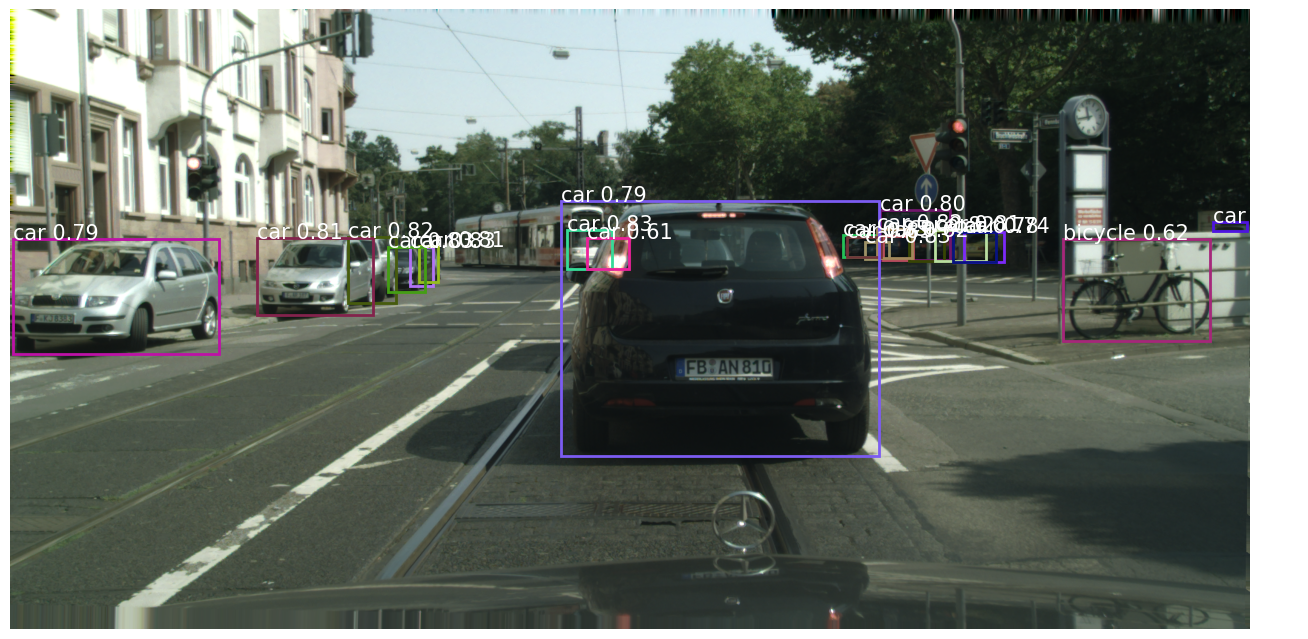

In [355]:
image, output = next(iter(zip(images, decoded_outputs)))
NO_OBJECT_ID = MAX_CLASS_ID + 1

detections = list(zip(output['scores'].tolist(), output['labels'].tolist(), output['boxes'].tolist()))
detections = list(filter(lambda x: x[1] != NO_OBJECT_ID, detections))

categories = [cityscapesAPIs['val'].getCategoryById(d[1]) for d in detections]

scores, labels, boxes = list(zip(*detections))
detections = list(zip(scores, categories, boxes))

drawDetections(image, detections, include_noInstances=False)

In [348]:
model.detr = detection_Detr_pl.model

In [349]:
# save the model
model.save_pretrained(PATH_SAVE_EXPERIMENT / 'detr')